# **Estimación de dirección de arribo de fuentes sonoras**



## 1.   En primera instancia, se instalan y se importan las librerias a utilizar.


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.signal import correlate
import pyroomacoustics as pra
import soundfile as sf
from IPython.display import Audio
from scipy.fft import fft, ifft
from scipy.signal import correlate

## 2. Simulación del entorno acústico

Como primer acercamiento, se lleva a cabo la simulación de una habitación. Para realizar este proceso, se importa audio anecóico.

In [37]:
signal, fs = sf.read("imp.wav") # Importo audio e imprimo su Frecuencia de muestreo
print(f"Frecuencia de muestreo: {fs} Hz")

signal = signal/np.max(signal)

Frecuencia de muestreo: 48000 Hz


Se plantean las características de la habitación, la posición de los micrófonos y de la fuente. Para esta primera simulación se considera que la sala simulada será anecóica.

In [38]:
room_dim = [10, 10]  # Dimensiones de la sala
mic_dist = .1 # Separación de micrófonos en metros

# Coordenadas de los micrófonos
mic_start = [0.85, 1]  # posición del primer micrófono

# Se agregan los micrófonos restantes cada mic_dist
mic_positions = np.array([
    [mic_start[0] + i * mic_dist, mic_start[1]] for i in range(4)
]).T

# Se crea sala y se agrega fuente
room = pra.ShoeBox(room_dim, fs=fs, max_order=0)
source_position = [5, 5]
room.add_source(source_position, signal=signal)

# Se agrega arreglo de micrófonos
room.add_microphone_array(pra.MicrophoneArray(mic_positions, room.fs))

room.simulate()

Se crea gráfico con posición de los elementos.

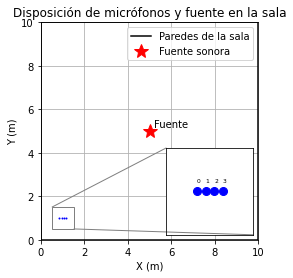

In [39]:
# Se calculan posiciones de los micrófonos para el gráfico
mic_positions = np.array([
    [mic_start[0] + i * mic_dist, mic_start[1]] for i in range(4)
])

# Crear gráfico
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, room_dim[0])
ax.set_ylim(0, room_dim[1])
ax.set_aspect('equal')
ax.grid(True)

# Dibujar sala
ax.plot([0, room_dim[0], room_dim[0], 0, 0],
        [0, 0, room_dim[1], room_dim[1], 0],
        'k-', label='Paredes de la sala')

# Dibujar micrófonos
for i, (x, y) in enumerate(mic_positions):
    ax.plot(x, y, 'bo', markersize=1)
    #ax.text(x + 0.05, y + 0.05, f'Mic{i}', fontsize=2)
    
axins = inset_axes(ax, width="40%", height="40%", loc='lower right')
axins.set_xlim(0.5, 1.5)
axins.set_ylim(0.5, 1.5)

# Repetir dibujo de micrófonos en el inset
for i, (x, y) in enumerate(mic_positions):
    axins.plot(x, y, 'bo', markersize=8)
    axins.text(x, y + 0.1, f'{i}', fontsize=6)

axins.set_xticks([])
axins.set_yticks([])
#axins.set_title('Zoom micrófonos', fontsize=8)

# Conectar inset con el eje principal
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


# Dibujar fuente
ax.plot(source_position[0], source_position[1], 'r*', markersize=15, label='Fuente sonora')
ax.text(source_position[0] + 0.2, source_position[1] + 0.2, 'Fuente', fontsize=10)

# Etiquetas y leyenda
ax.set_title('Disposición de micrófonos y fuente en la sala')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.legend()

plt.show()

Se confirma que el audio se haya simulado correctamente en la habitación, escuchando el audio resultante.

In [40]:
signals = room.mic_array.signals  # señales grabadas por los micrófonos

Audio(signals[0], rate=fs)


## 3. Estimación de TDOA (Time Difference of Arrival)

Se crea la función que obtendra el TDOA de la forma clasica y que servira para graficar la correlación.

In [41]:
def estimate_tdoa(sig1, sig2, fs):
    corr = correlate(sig1, sig2, mode='full')
    lag = np.argmax(corr) - (len(sig2) - 1)
    return lag / fs  # tiempo en segundos

In [42]:
def corr_norm(sig1, sig2, fs):
    corr = correlate(sig1, sig2, mode='full')
    lag = (np.argmax(corr) - (len(sig2) - 1))/fs
    return lag, corr/np.abs(np.max(corr))

Se aplica para cada par de micrófonos y se grafica lo que capta un solo par, además de su correlación cruzada.

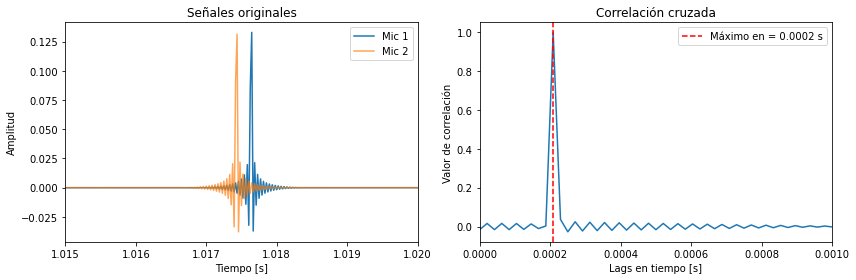

In [43]:
# Usá señales válidas del arreglo, por ejemplo:
sig1 = signals[0]  # señal del micrófono 1
sig2 = signals[1]  # señal del micrófono 2

lag, corr = corr_norm (sig1, sig2, fs)

# Ahora llamo la función
tdoa = estimate_tdoa(sig1, sig2, fs)

t = np.arange(len(sig1))/fs

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, sig1, label='Mic 1')
plt.plot(t, sig2, label='Mic 2', alpha=0.7)
plt.title('Señales originales')
plt.xlabel('Tiempo [s]')
plt.xlim(1.015, 1.02)
plt.ylabel('Amplitud')
plt.legend()

# 2. Graficar la correlación cruzada
lags = np.arange(-len(sig2)+1, len(sig1))/fs
plt.subplot(1, 2, 2)
plt.plot(lags, corr)
plt.axvline(lag, color='r', linestyle='--', label=f'Máximo en = {round(lag, 4)} s')
plt.title('Correlación cruzada')
plt.xlabel('Lags en tiempo [s]')
plt.xlim(-0.00, 0.001)
plt.ylabel('Valor de correlación')
plt.legend()

plt.tight_layout()
plt.show()

Se plantean los valores de TDOA entre cada par de micrófonos.

In [44]:
fs = room.fs
tdoa_01 = tdoaGCC_01 = gcc_tdoa_simple(signals[0], signals[1], fs,'classic', None)

tdoa_12 = tdoaGCC_01 = gcc_tdoa_simple(signals[1], signals[2], fs,'classic', None)

tdoa_23 = gcc_tdoa_simple(signals[2], signals[3], fs,'classic', None)


print(tdoa_01*1000,"ms entre MIC1-2")
print(tdoa_12*1000,"ms entre MIC2-3")
print(tdoa_23*1000,"ms entre MIC3-4")

0.20833333333333334 ms entre MIC1-2
0.20833333333333334 ms entre MIC2-3
0.20833333333333334 ms entre MIC3-4


Finalmente, para casos de estudio no anecoicos se genera la siguiente función que permite hacer uso de los demas metodos de correlación. En este caso, se permite utilizar el Phat, Scot, Roth y la Clasica

In [45]:
def gcc_tdoa_simple(sig1, sig2, fs, method='phat', max_tau=None):
    """
    Estima el retardo entre sig1 y sig2 con signo consistente con scipy.signal.correlate.
    
    Estima el retardo entre dos señales usando GCC.

    Parámetros:
        sig1, sig2 : señales de entrada (arrays 1D).
        fs : frecuencia de muestreo [Hz].
        method : 'phat', 'scot', 'roth', o 'classic'.
        max_tau : retardo máximo esperado [s], opcional.

    Retorna:
        Retardo estimado en segundos (float).
    """
    n = len(sig1) + len(sig2) - 1  # ajustar longitud total

    if method == 'classic':
        cc = correlate(sig1, sig2, mode='full')
    else:
        SIG1 = fft(sig1, n=n)
        SIG2 = fft(sig2, n=n) #zero padding para lograr que la convolucion circular sea igual a la lineal
        G = SIG1 * np.conj(SIG2) #Espectro de la correlación cruzada

        P1 = np.abs(SIG1) ** 2
        P2 = np.abs(SIG2) ** 2

        if method == 'phat':
            W = 1 / (np.abs(G) + 1e-12)
        elif method == 'scot':
            W = 1 / (np.sqrt(P1 * P2) + 1e-12)
        elif method == 'roth':
            W = 1 / (P2 + 1e-12)
        else:
            raise ValueError("Método inválido. Usar 'phat', 'scot', 'roth' o 'classic'.")

        G_weighted = G * W
        cc = np.real(ifft(G_weighted))
        cc = np.fft.fftshift(cc)

    # eje de lags como en correlate
    lags = np.arange(- (n // 2), (n + 1) // 2)
    t_lags = lags / fs

    if max_tau is not None:
        mask = np.abs(t_lags) <= max_tau
        cc = cc[mask]
        t_lags = t_lags[mask]

    # este es el valor con convención correcta
    return t_lags[np.argmax(cc)]

## 4. Cálculo del ángulo de llegada (DOA)

Se sabe que la diferencia de tiempo de arribo entre micrófonos ante un frente de onda plano está dado por:

\begin{equation}
    \tau = \frac{d \cdot \cos(\theta)}{c}
\end{equation}



Despejando el ángulo de incidencia:

In [46]:
c = 343  # velocidad del sonido en m/s

def tdoa_to_angle(tdoa, d, c):
    cos_theta = tdoa * c / d
    cos_theta = np.clip(cos_theta, -1, 1)
    return np.degrees(np.arccos(cos_theta))

Se estima el ángulo de llegada final, promediando los medidos en cada par de micrófonos. Para esto se utilizaran las tdoa obtenidas por el metodo clasico.

In [47]:
angle_01 = tdoa_to_angle(tdoa_01, mic_dist, c)
angle_12 = tdoa_to_angle(tdoa_12, mic_dist, c)
angle_23 = tdoa_to_angle(tdoa_23, mic_dist, c)



doa_final = np.mean([angle_01, angle_12, angle_23])

print(str(round(doa_final, 2)) + "°")

44.39°
